# Softmax function and its derivative

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import copy
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True)) 
    return exp_x / np.sum(exp_x, axis=1, keepdims=True) 

def softmax_derivative(softmax_output):
    batch_size = softmax_output.shape[0]
    S = np.zeros((batch_size, softmax_output.shape[1], softmax_output.shape[1]))  
    for i in range(batch_size):
        s = softmax_output[i].reshape(-1, 1)  
        S[i] = np.diagflat(s) - np.dot(s, s.T)  # Compute Jacobian  
    return S

def initialize_K(L):
    K = []
    for i in range(1, len(L)):
        K.append(np.random.randn(L[i-1], L[i])* np.sqrt(2 / L[i-1]))
    return K

# Forward and Backward propagartion without noise using SGD

In [4]:
def forward_pass(q, K):
    A = [q]  
    Z = []
    for i in range(len(K)):
        z = np.dot(A[-1], K[i])  
        activation = softmax(z)  
        A.append(activation)  
        Z.append(z)   
    return A, Z

def backward_pass(A, Z, Y, K):
    L = len(K)  
    deltas = [None] * L  
    jacobian = softmax_derivative(A[-1])  
    deltas[-1] = np.einsum("ijk,ik->ij", jacobian, (A[-1] - Y))  
    for l in range(L - 1, 0, -1): 
        activation_derivative = softmax_derivative(A[l])  
        deltas[l-1] = np.einsum("ijk,ik->ij", activation_derivative, np.dot(deltas[l], K[l].T))
    gradients = [np.dot(A[l].T, deltas[l]) for l in range(L)]
    return gradients


def train(q, Y, K, learning_rate, epochs, batch_size):
    loss_values = []
    weights_per_epoch = {}
    for epoch in range(epochs):
        indices = np.random.permutation(len(q))  
        weights_per_epoch[epoch] = [[np.copy(k) for k in K]]  
        for start_idx in range(0, len(q), batch_size):
            end_idx = min(start_idx + batch_size, len(q))
            q_batch, Y_batch = q[start_idx:end_idx], Y[start_idx:end_idx] 
            Ai, Zi = forward_pass(q_batch, K)  
            gradients = backward_pass(Ai, Zi, Y_batch, K)  
            for i in range(len(K)):
                K[i] -= learning_rate * gradients[i] 
        A, Z = forward_pass(q, K)
        loss = np.mean((A[-1] - Y) ** 2)    
        loss_values.append(loss)  
    return A, K, loss_values, weights_per_epoch


# Forward and Backward propagartion with noise using SGD

In [6]:
def add_noise(q, num):
    m,e = np.frexp(q)
    m = np.round(m, num)
    return m*2.0**e
    
def P_forward_pass(q, K_P, num):
    A_P = [q]  
    Z_P = []
    for i in range(len(K_P)):
        z = np.dot(add_noise(A_P[-1],num), K_P[i])  
        activation = softmax(add_noise(z,num)) 
        A_P.append(activation)  
        Z_P.append(z)   
    return A_P, Z_P

def P_backward_pass(A_P, Z_P, Y, K_P,num):
    L = len(K_P)  
    deltas_P = [None] * L  
    jacobian = softmax_derivative(A_P[-1])
    deltas_P[-1] = np.einsum("ijk,ik->ij", jacobian, (A_P[-1] - Y))  
    for l in range(L - 1, 0, -1): 
        activation_derivative = softmax_derivative(A_P[l])
        deltas_P[l-1] = np.einsum("ijk,ik->ij", activation_derivative, np.dot(deltas_P[l], K_P[l].T))
    gradients_P = [np.dot(A_P[l].T, deltas_P[l]) for l in range(L)]
    return gradients_P

def P_train(q, Y, K_P, learning_rate, epochs, num, batch_size):
    loss_values_P = []
    weights_per_epoch_P = {}
    for epoch in range(epochs):
        indices = np.random.permutation(len(q))  
        weights_per_epoch_P[epoch] = [[np.copy(k) for k in K_P]]
        for start_idx in range(0, len(q), batch_size):
            end_idx = min(start_idx + batch_size, len(q))
            q_batch, Y_batch = q[start_idx:end_idx], Y[start_idx:end_idx]
            Ai_P, Zi_P = P_forward_pass(q_batch, K_P, num)
            gradients_P = P_backward_pass(Ai_P, Zi_P, Y_batch, K_P, num)
            for i in range(len(K_P)):
                K_P[i] -= learning_rate * gradients_P[i]
        A_P, Z_P = P_forward_pass(q, K_P, num)
        # Compute the loss
        mse_loss = np.mean((A_P[-1] - Y) ** 2)
        loss_values_P.append(mse_loss)    
    return A_P,K_P,loss_values_P, weights_per_epoch_P

# Initialization of input data.

In [8]:
input_dim = 4; output_dim = 4; num_samples = 10
np.random.seed(42)
q = np.random.randn(num_samples, input_dim) 
W_true = np.random.randn(input_dim, output_dim)
Y_linear = np.dot(q, W_true)
Y = softmax(Y_linear) 
hidden_layers = [4]*2
L = [input_dim] + hidden_layers + [output_dim]  
learning_rate = 0.1
epochs=100
num = 4
batch_size = 4
# Run forward and backward passes
K = initialize_K(L)  
K_P = copy.deepcopy(K)

### Average Relative Error between Weights and Perturbed Weights per epoch for at difference number of layers

In [10]:
def relative_error(A, B):
    numerator = np.linalg.norm(A - B, 'fro')
    denominator = np.linalg.norm(A, 'fro')
    return numerator / denominator


# List of hidden layer configurations
hidden_layer_counts = [10,20,50,70,100]
# Initialize storage for errors
relative_errors = {}

# Loop over different hidden layer configurations
for n in hidden_layer_counts:
    # Define the architecture
    hidden_layers = [16] * n
    L = [input_dim] + hidden_layers + [output_dim]
    K = initialize_K(L)  
    K_P = copy.deepcopy(K)
    # Train the network
    _,K,loss_values,A =train(q, Y, K, learning_rate, epochs, batch_size)
    # Train the network
    _,K_P,loss_values_P,B = P_train(q, Y, K_P, learning_rate, epochs,num, batch_size)
    for key in A:
        A[key] = A[key][0] 

    for key in B:
        B[key] = B[key][0] 
    av_errors = []
    for key in A:
        H1 = A[key]
        H2 = B[key]
        errors = []
        for i in range(len(L)-1):
            error = relative_error(H1[i], H2[i])
            errors.append(error)
        av_errors.append(np.mean(errors))    
    # Store errors for this configuration
    relative_errors[n] = av_errors

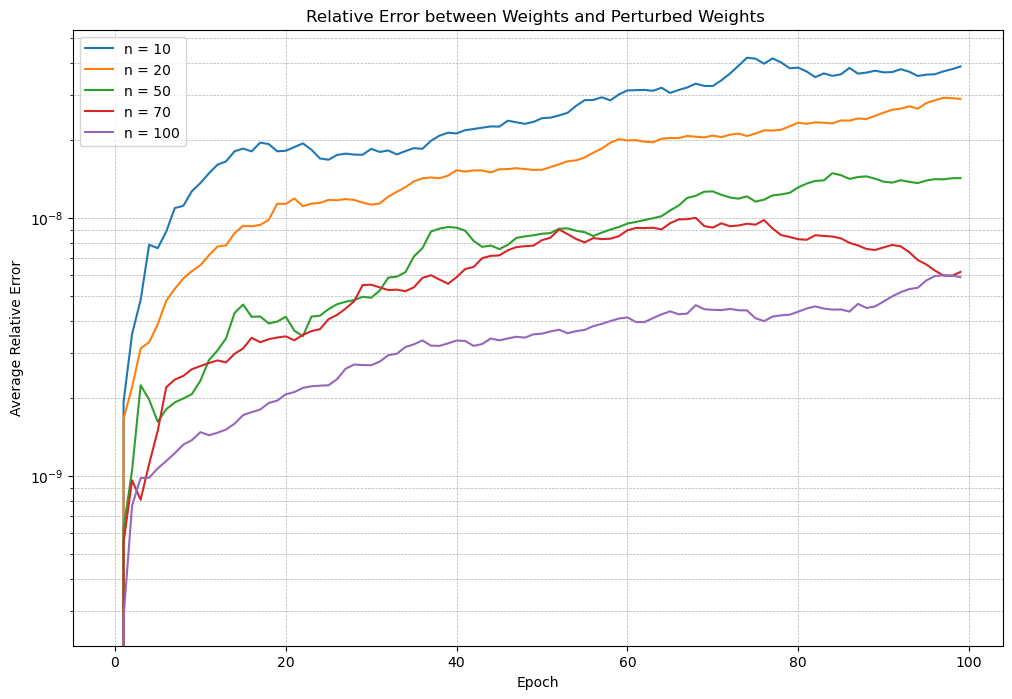

In [11]:
# Plot all errors on the same figure
plt.figure(figsize=(12, 8))
for n, errors in relative_errors.items():
    plt.semilogy(errors, label=f'n = {n}', linestyle='-')
    
plt.title("Relative Error between Weights and Perturbed Weights ")
plt.xlabel("Epoch")
plt.ylabel("Average Relative Error")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

### Average Relative Error between Weights and Perturbed Weights per epoch for at difference number of neurals

In [13]:
n=20  
neuron_configs = [4,16,32,64]
relative_errorsN = {}
for neurons in neuron_configs:
    hidden_layers = [neurons] * n
    L = [input_dim] + hidden_layers + [output_dim]
    K = initialize_K(L)  
    K_P = copy.deepcopy(K)
    _,K,loss_values,A =train(q, Y, K, learning_rate, epochs, batch_size)
    _,K_P,loss_values_P,B = P_train(q, Y, K_P, learning_rate, epochs,num, batch_size)
    for key in A:
        A[key] = A[key][0] 
    for key in B:
        B[key] = B[key][0] 
    av_errors = []
    for key in A:
        H1 = A[key]
        H2 = B[key]
        errors = []
        for i in range(len(L)-1):
            error = relative_error(H1[i], H2[i])
            errors.append(error)
        av_errors.append(np.mean(errors))    
    relative_errorsN[neurons] = av_errors

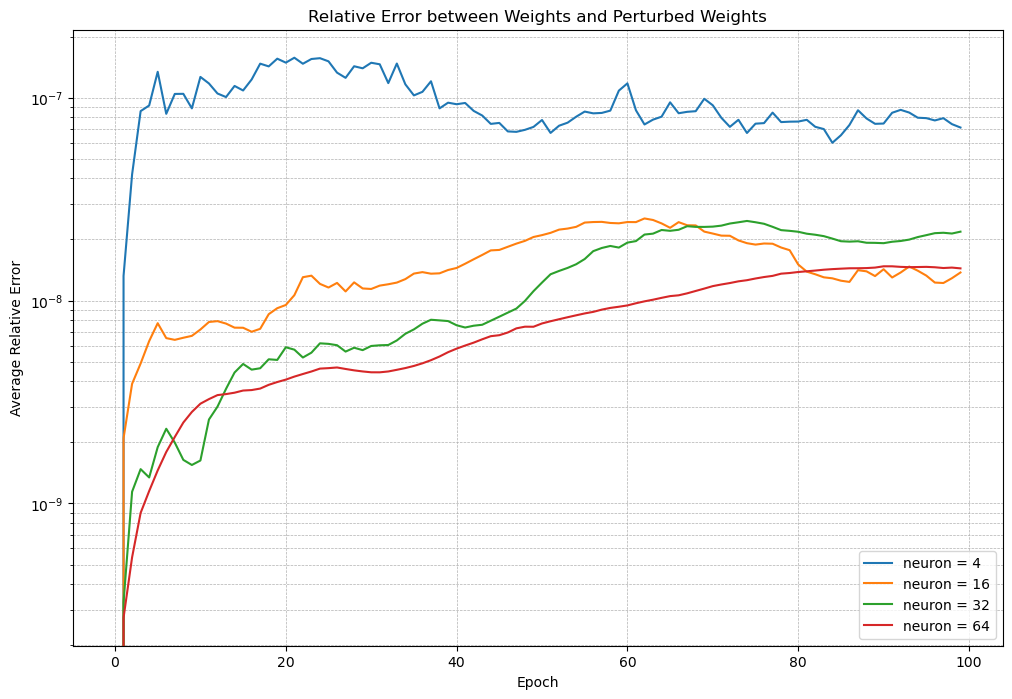

In [14]:
# Plot all errors on the same figure
plt.figure(figsize=(12, 8))
for neurons, errors in relative_errorsN.items():
    plt.semilogy(errors, label=f'neuron = {neurons}', linestyle='-')
    
plt.title("Relative Error between Weights and Perturbed Weights")
plt.xlabel("Epoch")
plt.ylabel("Average Relative Error")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

### Average Relative Error between Weights and Perturbed Weights per epoch for at difference number of round.

In [16]:
n=20  # Number of layers
hidden_layers = [16] * n
L = [input_dim] + hidden_layers + [output_dim]
nums = [1,2,3,4,5]

# Initialize storage for errors
relative_errorsP = {}
for num in nums: 
    K = initialize_K(L)  
    K_P = copy.deepcopy(K)
    _,K,loss_values,A =train(q, Y, K, learning_rate, epochs, batch_size)
    _,K_P,loss_values_P,B = P_train(q, Y, K_P, learning_rate, epochs, num, batch_size)
    for key in A:
        A[key] = A[key][0] 

    for key in B:
        B[key] = B[key][0] 
    av_errors = []
    for key in A:
        H1 = A[key]
        H2 = B[key]
        errors = []
        for i in range(len(L)-1):
            error = relative_error(H1[i], H2[i])
            errors.append(error)
        av_errors.append(np.mean(errors))    
    relative_errorsP[num] = av_errors

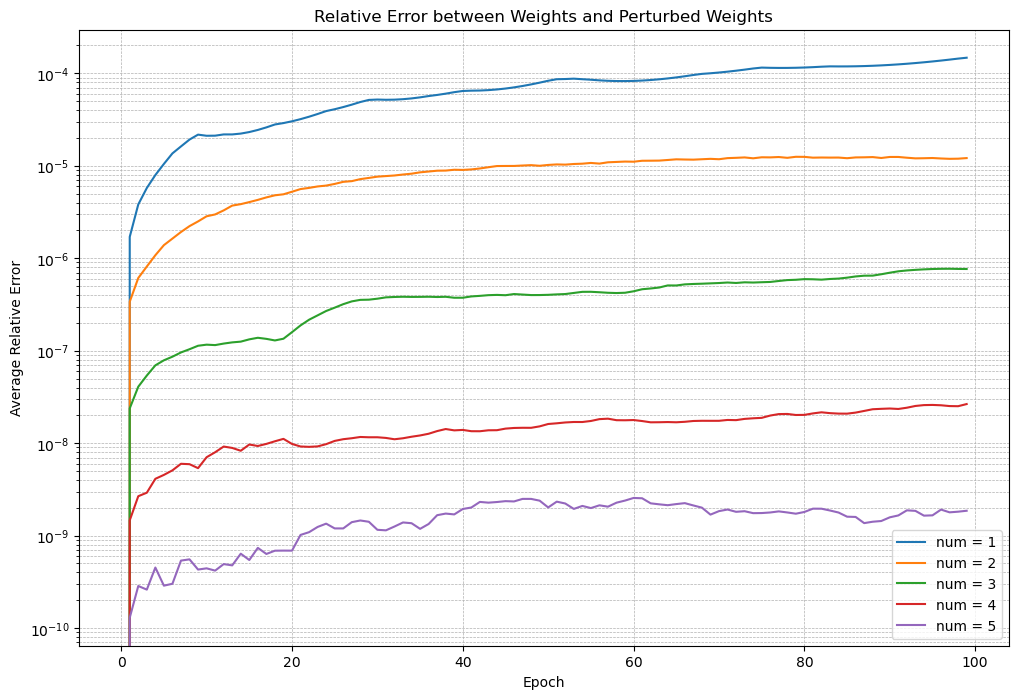

In [17]:
# Plot all errors on the same figure
plt.figure(figsize=(12, 8))
for i, errors in relative_errorsP.items():
    plt.semilogy(errors, label=f'num = {i}', linestyle='-')
    
plt.title("Relative Error between Weights and Perturbed Weights")
plt.xlabel("Epoch")
plt.ylabel("Average Relative Error")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()